In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('todo.xlsx')

In [4]:
df.head()

,municipio,año,mes,hombres,mujeres,total
0,1,2018,1,1,2,3
1,1,2018,5,1,0,1
2,1,2018,7,1,2,3
3,1,2018,8,2,0,2
4,1,2018,9,1,3,4


<Axes: >

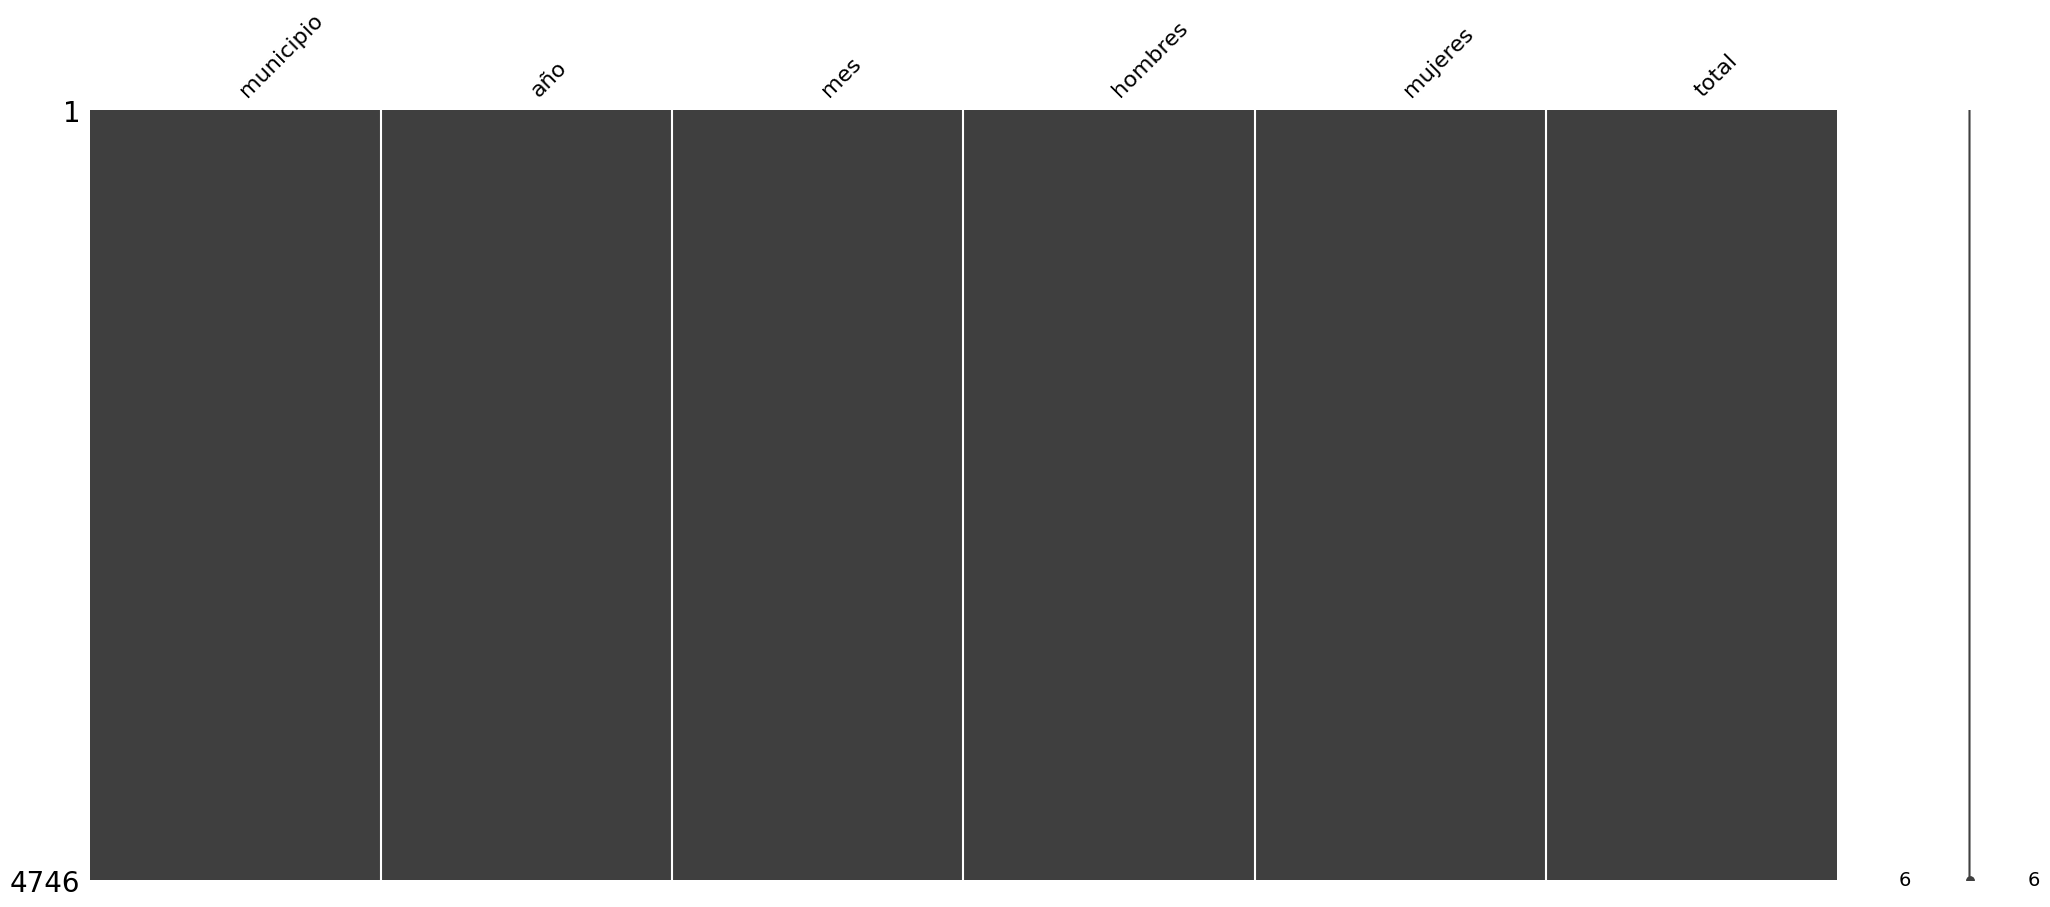

In [5]:
import missingno as msno
msno.matrix(df)

In [6]:
df.isnull().sum()

municipio    0
año          0
mes          0
hombres      0
mujeres      0
total        0
dtype: int64

In [7]:
df_agrupado = df.groupby(['municipio', 'año'])['total'].sum().reset_index()

In [8]:
df_agrupado.to_csv('nacimientos_agrupadas.csv', index=False)
df_agrupado.to_excel('nacimientos_agrupadas.xlsx', index=False)

In [9]:
df_agrupado.head(10)

,municipio,año,total
0,1,2018,23
1,1,2019,18
2,1,2020,32
3,1,2021,33
4,1,2022,21
5,1,2023,15
6,1,2024,16
7,2,2018,1333
8,2,2019,1215
9,2,2020,1054


In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [11]:
modelo = LinearRegression()

In [12]:
lista_municipios = df_agrupado['municipio'].unique()

resultados_predicciones = []
años_futuros = np.array([2025, 2026, 2027, 2028, 2029]).reshape(-1, 1)

In [13]:
for municipio_id in lista_municipios:
    print(f"Procesando Municipio {municipio_id}...")
    
    df_municipio = df_agrupado[df_agrupado['municipio'] == municipio_id]
    
    if len(df_municipio) > 1:
        X = df_municipio['año'].values.reshape(-1, 1)
        y = df_municipio['total'].values
        
        modelo = LinearRegression()
        modelo.fit(X, y)
        
        prediccion_futura = modelo.predict(años_futuros)
        
        for i, año in enumerate(años_futuros.flatten()):
            resultados_predicciones.append({
                'municipio': municipio_id,
                'año_prediccion': año,
                'total_predicho': prediccion_futura[i]
            })

Procesando Municipio 1...
Procesando Municipio 2...
Procesando Municipio 3...
Procesando Municipio 4...
Procesando Municipio 5...
Procesando Municipio 6...
Procesando Municipio 8...
Procesando Municipio 9...
Procesando Municipio 10...
Procesando Municipio 11...
Procesando Municipio 12...
Procesando Municipio 13...
Procesando Municipio 14...
Procesando Municipio 15...
Procesando Municipio 16...
Procesando Municipio 17...
Procesando Municipio 18...
Procesando Municipio 19...
Procesando Municipio 20...
Procesando Municipio 21...
Procesando Municipio 22...
Procesando Municipio 23...
Procesando Municipio 24...
Procesando Municipio 25...
Procesando Municipio 26...
Procesando Municipio 27...
Procesando Municipio 28...
Procesando Municipio 29...
Procesando Municipio 30...
Procesando Municipio 31...
Procesando Municipio 32...
Procesando Municipio 33...
Procesando Municipio 34...
Procesando Municipio 35...
Procesando Municipio 36...
Procesando Municipio 37...
Procesando Municipio 38...
Procesand

In [14]:
df_resultados = pd.DataFrame(resultados_predicciones)

print("\n--- PREDICCIONES FINALES ---")
print(df_resultados)


--- PREDICCIONES FINALES ---
     municipio  año_prediccion  total_predicho
0            1            2025       17.142857
1            1            2026       15.785714
2            1            2027       14.428571
3            1            2028       13.071429
4            1            2029       11.714286
..         ...             ...             ...
340         72            2025      118.857143
341         72            2026      103.214286
342         72            2027       87.571429
343         72            2028       71.928571
344         72            2029       56.285714

[345 rows x 3 columns]


In [15]:
df_historico_plot = df_agrupado.copy()
df_historico_plot['tipo'] = 'Histórico'

df_prediccion_plot = df_resultados.copy()
df_prediccion_plot.rename(columns={
    'año_prediccion': 'año',
    'total_predicho': 'total'
}, inplace=True)
df_prediccion_plot['tipo'] = 'Predicción'

df_completo = pd.concat([df_historico_plot, df_prediccion_plot])

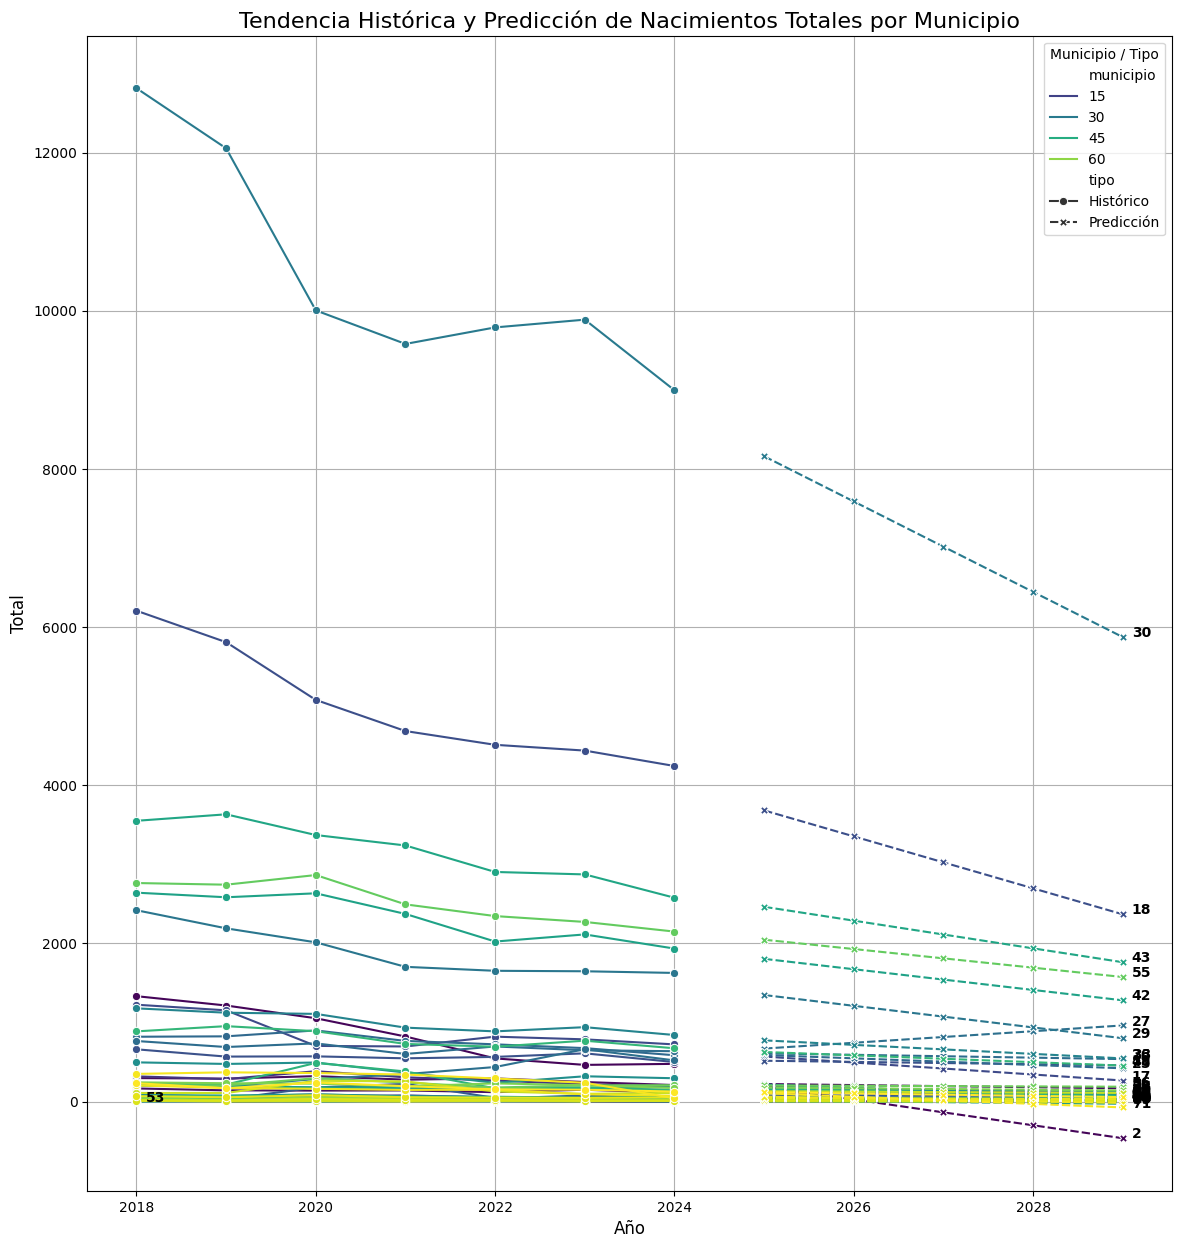

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 15))

sns.lineplot(
    data=df_completo,
    x='año',
    y='total',
    hue='municipio',
    style='tipo',
    markers=True,
    palette='viridis'
)

for municipio_id in df_completo['municipio'].unique():
    df_municipio = df_completo[df_completo['municipio'] == municipio_id]
    
    df_municipio = df_municipio.sort_values(by='año')
    
    ultimo_punto = df_municipio.iloc[-1]
    x_pos = ultimo_punto['año']
    y_pos = ultimo_punto['total']
    
    plt.text(x_pos + 0.1, y_pos, str(municipio_id), 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Tendencia Histórica y Predicción de Nacimientos Totales por Municipio', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.legend(title='Municipio / Tipo') 
plt.grid(True)
plt.savefig("prediccion_nacimientos")
plt.show()

In [17]:
from prophet import Prophet

lista_municipios = df_agrupado['municipio'].unique()

todos_los_pronosticos = []

for municipio_id in lista_municipios:
    print(f"Procesando pronóstico para el Municipio {municipio_id}...")
    
    df_municipio = df_agrupado[df_agrupado['municipio'] == municipio_id].copy()
    
    if len(df_municipio) > 1:
        df_prophet = df_municipio[['año', 'total']].rename(columns={
            'año': 'ds',
            'total': 'y'
        })
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
        
        modelo_prophet = Prophet()
        modelo_prophet.fit(df_prophet)
        
        futuro = modelo_prophet.make_future_dataframe(periods=5, freq='Y')
        pronostico = modelo_prophet.predict(futuro)
        
        pronostico['municipio'] = municipio_id
        
        todos_los_pronosticos.append(pronostico)

df_final_prophet = pd.concat(todos_los_pronosticos)

print("\n--- PRONÓSTICOS FINALES CON PROPHET ---")
print(df_final_prophet.tail(10))

c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
09:39:21 - cmdstanpy - INFO - Chain [1] start processing
09:39:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 1...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:21 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 2...


09:39:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:22 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 3...


09:39:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:22 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 4...


09:39:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:22 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 5...


09:39:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:23 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 6...


09:39:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:23 - cmdstanpy - INFO - Chain [1] start processing
09:39:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 8...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:23 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 9...


09:39:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:23 - cmdstanpy - INFO - Chain [1] start processing
09:39:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 10...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:24 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 11...


09:39:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:24 - cmdstanpy - INFO - Chain [1] start processing
09:39:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 12...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:24 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 13...


09:39:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:25 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 14...


09:39:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:25 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 15...


09:39:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:25 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 16...


09:39:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:26 - cmdstanpy - INFO - Chain [1] start processing
09:39:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 17...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:26 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 18...


09:39:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:26 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 19...


09:39:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:27 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 20...


09:39:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:27 - cmdstanpy - INFO - Chain [1] start processing
09:39:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 21...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:27 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 22...


09:39:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:28 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 23...


09:39:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:28 - cmdstanpy - INFO - Chain [1] start processing
09:39:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 24...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:28 - cmdstanpy - INFO - Chain [1] start processing
09:39:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 25...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:28 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 26...


09:39:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:29 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 27...


09:39:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:29 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 28...


09:39:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:29 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 29...


09:39:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:41 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 30...


09:39:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:42 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 31...


09:39:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:42 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 32...


09:39:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:43 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 33...


09:39:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Procesando pronóstico para el Municipio 34...


09:39:43 - cmdstanpy - INFO - Chain [1] start processing
09:39:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:44 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 35...


09:39:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:44 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 36...


09:39:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:39:45 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 37...


09:39:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Procesando pronóstico para el Municipio 38...


09:42:17 - cmdstanpy - INFO - Chain [1] start processing
09:42:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:19 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 39...


09:42:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:19 - cmdstanpy - INFO - Chain [1] start processing
09:42:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 40...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:20 - cmdstanpy - INFO - Chain [1] start processing
09:42:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 41...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:20 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 42...


09:42:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:21 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 43...


09:42:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:22 - cmdstanpy - INFO - Chain [1] start processing
09:42:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:22 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 44...
Procesando pronóstico para el Municipio 45...


09:42:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:22 - cmdstanpy - INFO - Chain [1] start processing
09:42:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 46...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:22 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 47...


09:42:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:23 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 48...


09:42:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:23 - cmdstanpy - INFO - Chain [1] start processing
09:42:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Procesando pronóstico para el Municipio 49...


09:42:23 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 50...


09:42:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:23 - cmdstanpy - INFO - Chain [1] start processing
09:42:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Procesando pronóstico para el Municipio 51...


09:42:24 - cmdstanpy - INFO - Chain [1] start processing
09:42:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 52...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:24 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 53...
Procesando pronóstico para el Municipio 55...


09:42:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:24 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 56...


09:42:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:24 - cmdstanpy - INFO - Chain [1] start processing
09:42:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 57...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:25 - cmdstanpy - INFO - Chain [1] start processing
09:42:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 58...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:25 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 59...


09:42:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:25 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 60...


09:42:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:26 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 61...


09:42:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:26 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 62...


09:42:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:26 - cmdstanpy - INFO - Chain [1] start processing
09:42:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 63...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:27 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 64...


09:42:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:27 - cmdstanpy - INFO - Chain [1] start processing
09:42:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 65...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:27 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 66...


09:42:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:27 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 67...


09:42:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:28 - cmdstanpy - INFO - Chain [1] start processing
09:42:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 68...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:28 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 69...


09:42:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:28 - cmdstanpy - INFO - Chain [1] start processing
09:42:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 70...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:29 - cmdstanpy - INFO - Chain [1] start processing
09:42:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando pronóstico para el Municipio 71...


c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
09:42:29 - cmdstanpy - INFO - Chain [1] start processing


Procesando pronóstico para el Municipio 72...


09:42:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\geo_s\Downloads\Nueva carpeta\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



--- PRONÓSTICOS FINALES CON PROPHET ---
           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2  2020-01-01  54.689888  172.156318  233.754487    54.689888    54.689888   
3  2021-01-01  38.637844  147.410839  208.072497    38.637844    38.637844   
4  2022-01-01  22.629659  131.019121  192.206317    22.629659    22.629659   
5  2023-01-01   6.621473  120.131138  180.640279     6.621473     6.621473   
6  2024-01-01  -9.386712  106.121561  169.289493    -9.386712    -9.386712   
7  2024-12-31 -25.394898   94.029061  154.849823   -25.394898   -25.394897   
8  2025-12-31 -41.403083   87.726343  146.627828   -41.403085   -41.403082   
9  2026-12-31 -57.411269   77.956841  139.143284   -57.411271   -57.411266   
10 2027-12-31 -73.419454   71.544698  136.305515   -73.419458   -73.419450   
11 2028-12-31 -89.471498   31.349916   93.506495   -89.471503   -89.471493   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
2       146.398358    

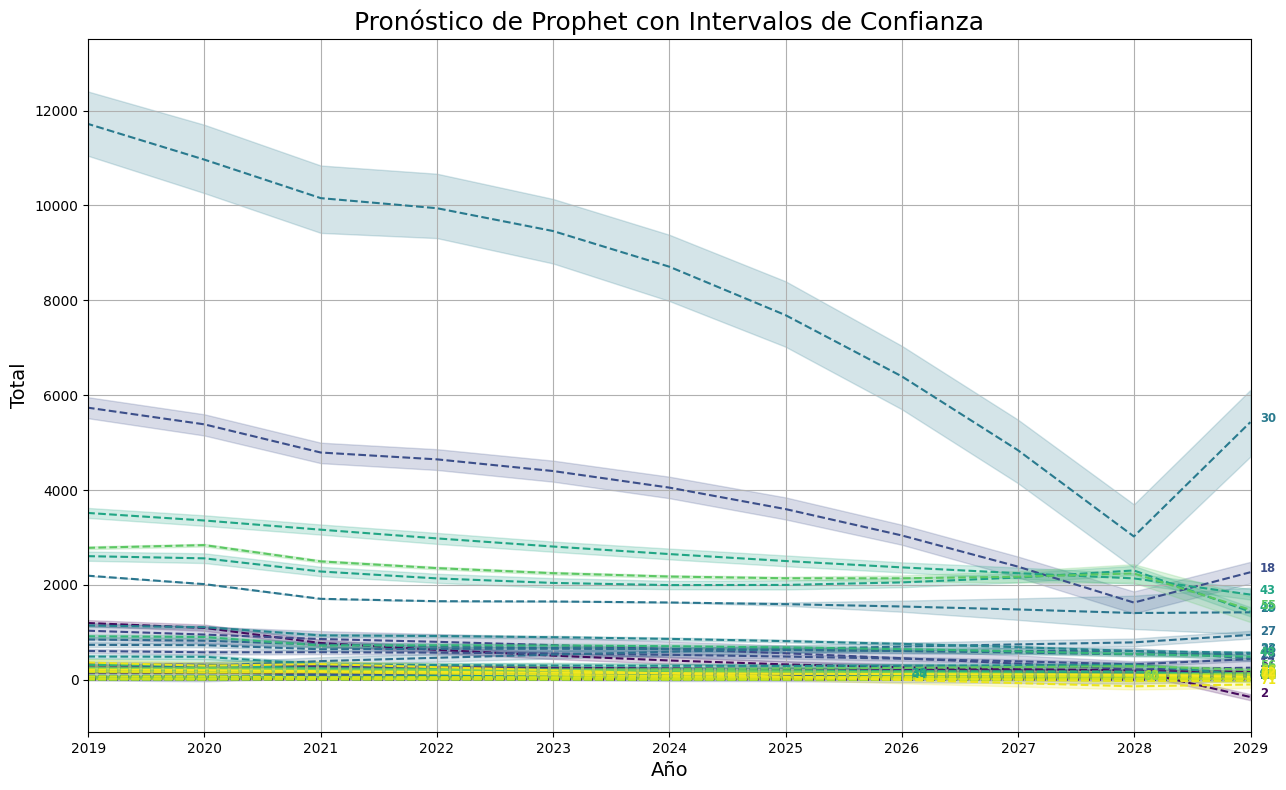

In [18]:
plt.figure(figsize=(15, 9))
ax = plt.gca()

lista_municipios = df_agrupado['municipio'].unique()
palette = sns.color_palette("viridis", n_colors=len(lista_municipios))

for i, municipio_id in enumerate(lista_municipios):
    
    color = palette[i]
    
    hist_data = df_agrupado[df_agrupado['municipio'] == municipio_id]
    forecast_data = df_final_prophet[df_final_prophet['municipio'] == municipio_id]
    
    ax.scatter(hist_data['año'], hist_data['total'], color=color, label=f'Datos Históricos Mun. {municipio_id}', s=50)
    
    ax.plot(forecast_data['ds'], forecast_data['yhat'], color=color, linestyle='--', label=f'Predicción Mun. {municipio_id}')
    
    ax.fill_between(
        forecast_data['ds'],
        forecast_data['yhat_lower'],
        forecast_data['yhat_upper'],
        color=color,
        alpha=0.2  
    )

    forecast_data = forecast_data.sort_values(by='ds')

    if not forecast_data.empty: 
        ultimo_punto_forecast = forecast_data.iloc[-1]
        x_pos = ultimo_punto_forecast['ds']
        y_pos = ultimo_punto_forecast['yhat']

        x_offset = pd.to_timedelta('30 days')
        y_offset = 10
        
        ax.text(x_pos + x_offset, y_pos + y_offset, str(municipio_id), 
                 horizontalalignment='left', size='small', color=color, weight='semibold')

ultimo_año_historico = df_agrupado['año'].max()
ultimo_año_prediccion = df_final_prophet['ds'].max().year

año_inicio_rango = ultimo_año_historico - 5
año_fin_rango = ultimo_año_prediccion + 1

ax.set_xlim(pd.to_datetime(f'{año_inicio_rango}-01-01'), pd.to_datetime(f'{año_fin_rango}-01-01'))

ax.set_title('Pronóstico de Prophet con Intervalos de Confianza', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Total', fontsize=14)
#ax.legend()
plt.grid(True)
plt.savefig("prediccion_prophet_nacimientos")
plt.show()